# Experimentación - DCRNN

https://arxiv.org/abs/1707.01926

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from sklearn.metrics import r2_score

from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils import train_lstm
from utils import trainer
import utils.train_lstm
dtype = torch.float
device = torch.device("cpu")

In [15]:
def eval(model, dataloader, device=torch.device("cpu")):
    model.eval()
    loss_eval, r2_eval = [], []
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)[:,:,0].to(device)  
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).mean(dim=-1).mean(dim=-1).to(device) 
        y = snapshot.y.to(device)

        y_hat= model(x, edge_index,edge_attr)
        loss = F.mse_loss(y_hat, y).item()
        r2_eval.append(r2_score(y.cpu(), y_hat.cpu()))
        loss_eval.append(loss)
    return loss_eval, r2_eval




def train(model,dataloader, num_early_stop, num_epochs, lr, device= torch.device("cpu")):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    for epoch in range(num_epochs):
        model.train()
        cost = 0
        for time, snapshot in enumerate(dataloader['train']):
            x = snapshot.x.to(device)  # Mover a GPU
            edge_index = snapshot.edge_index.permute(2, 1, 0)[:,:,0].to(device)  
            edge_attr = snapshot.edge_attr.permute(1, 0, 2).mean(dim=-1).mean(dim=-1).to(device) 
            y = snapshot.y.to(device)

            y_hat= model(x, edge_index,edge_attr)
            cost = cost + F.mse_loss(y_hat, y)
        
        cost = cost / (time+1)
        cost.backward(retain_graph=False)
        losses.append(cost.item())
        optimizer.step()
        optimizer.zero_grad()
            
        train_loss = cost

    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, device)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    print("\nTraining completed.")
    return losses, eval_losses, r2scores
    


def test(model, dataloader, save_predictions=True):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst, loss_nodes = [], [], []
    for time, snapshot in enumerate(dataloader['test']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0)[:,:,0].to(device)  
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).mean(dim=-1).mean(dim=-1).to(device) 
        y = snapshot.y.to(device)

        y_hat= model(x, edge_index,edge_attr)
        loss = F.mse_loss(y_hat, y).item()

        loss_per_node = F.mse_loss(y_hat, y, reduction='none').mean(dim=1).cpu().detach().numpy()
        loss_nodes.append(loss_per_node)

        preds = y_hat.view(model.n_nodes, model.n_target)
        r2score_tst.append(r2_score(y.detach().cpu(), y_hat.detach().cpu()))
        losses_tst.append(loss)
        if save_predictions:
            real.append(y.view(model.n_nodes, model.n_target).cpu().detach().numpy())
            predictions.append(preds.cpu().detach().numpy())
        
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, loss_nodes, predictions, real

In [16]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, hidden_dim):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        self.hidden_dim = hidden_dim
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(self.n_features,self.hidden_dim , 1)
        self.linear = torch.nn.Linear(self.hidden_dim, n_target)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## Prueba - predicción por tipos

In [17]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [18]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [19]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =32


dataloader_gt = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


#### Sencilla 

In [20]:
model = RecurrentGCN("DCRNN", n_features, n_nodes, n_target, hidden_size)

In [21]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
losses,eval_losses, r2scores = train(model, dataloader_gt, num_early_stop, num_epochs, lr, device)



==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1777 | Eval Loss: 0.5144 | Eval R2: -242.0189 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5092 | Eval Loss: 0.3227 | Eval R2: -144.5681 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.3217 | Eval Loss: 0.2117 | Eval R2: -88.4618 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.2143 | Eval Loss: 0.1443 | Eval R2: -54.2256 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1494 | Eval Loss: 0.1084 | Eval R2: -36.3318 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.1152 | Eval Loss: 0.0971 | Eval R2: -30.9402 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1047 | Eval Loss: 0.1025 | Eval R2: -33.7313 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1105 | Eval Loss: 0.1127 | Eval R2: -39.4723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.1211 | Eval Loss: 0.1182 | Eval R2: -43.3443 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.1267 | Eval Loss: 0.1179 | Eval R2: -43.2426 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.1263 | Eval Loss: 0.1166 | Eval R2: -42.6307 

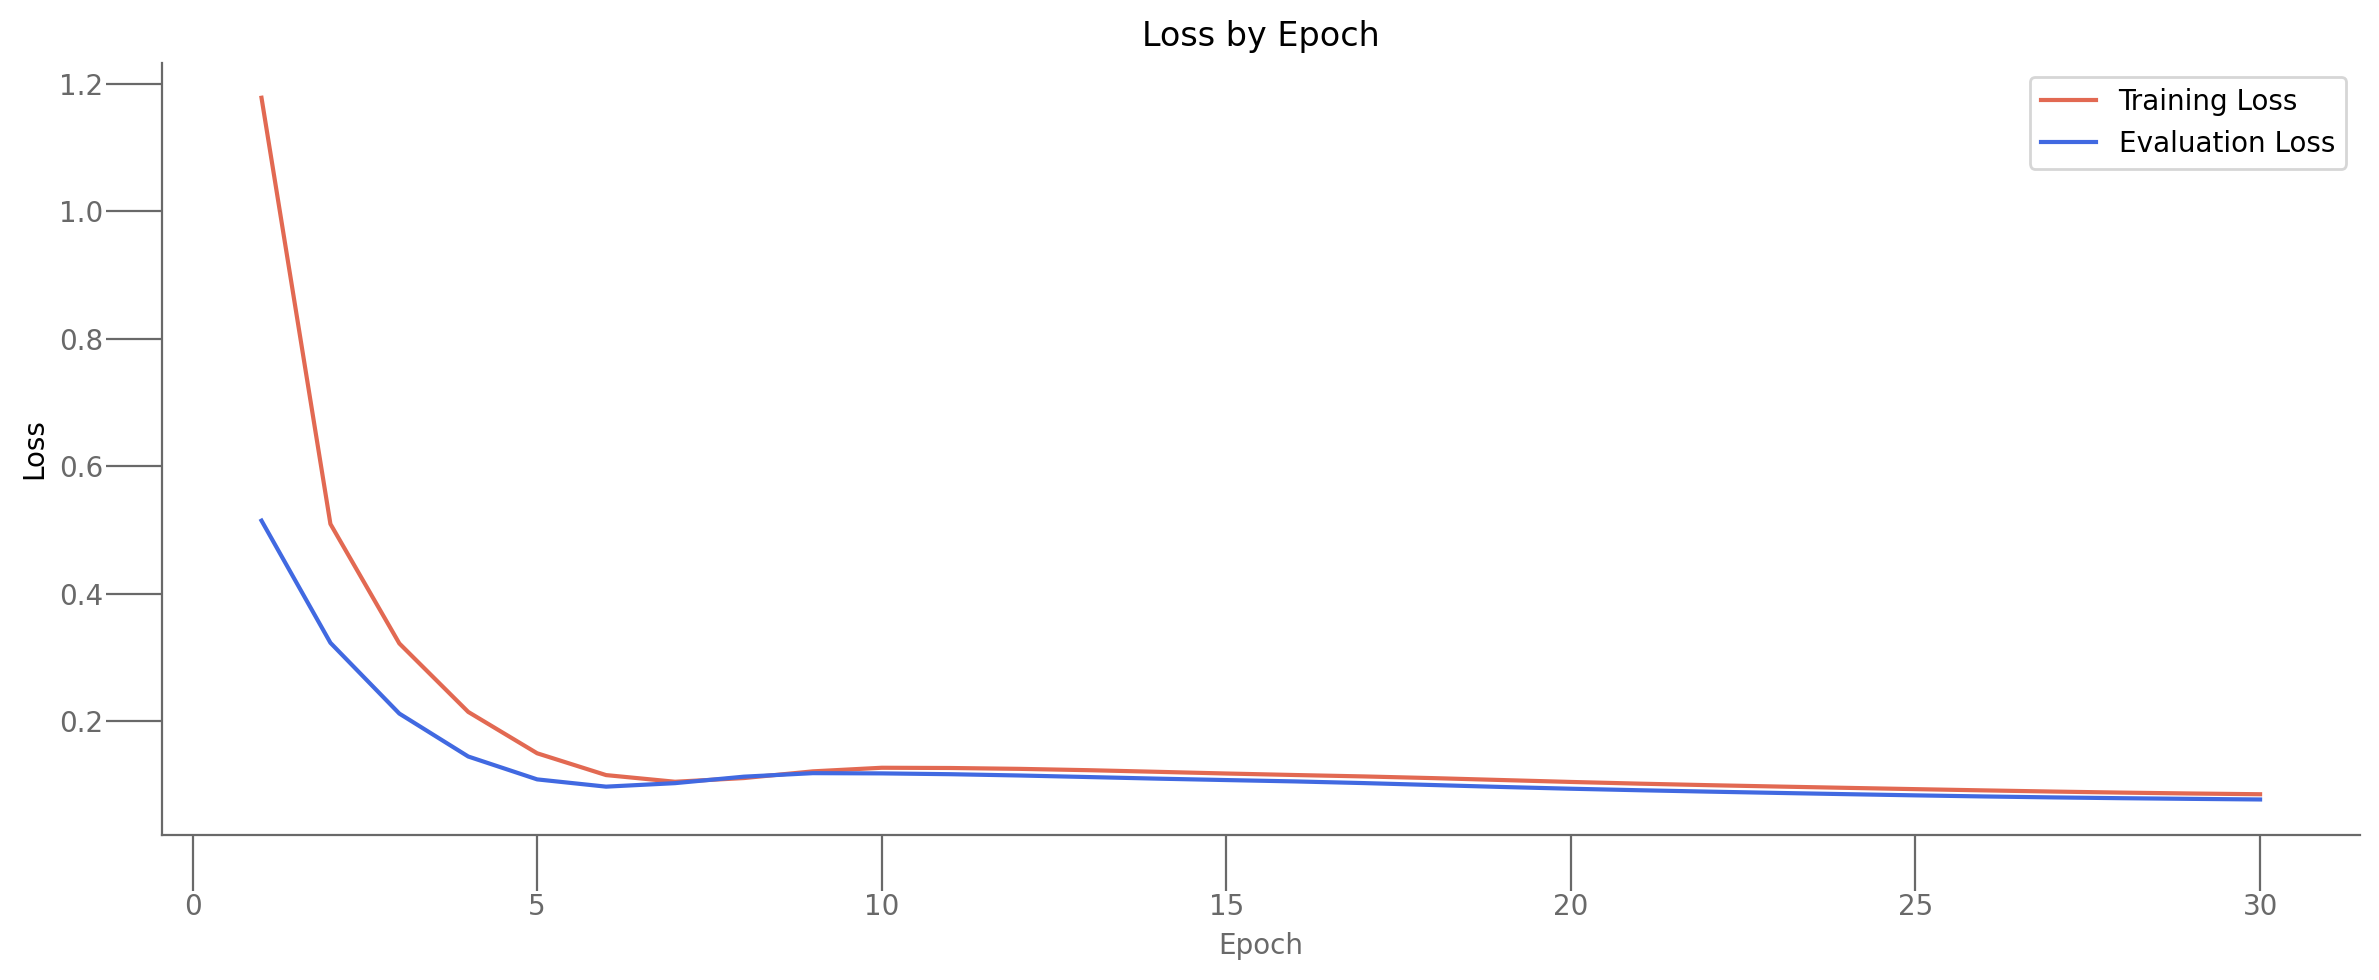


==================== TEST INFO ===================

Test_loss:0.0648, Test_r2:-25.1490


In [22]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_gt, predictions_gt, real_gt = test(model, dataloader_gt)

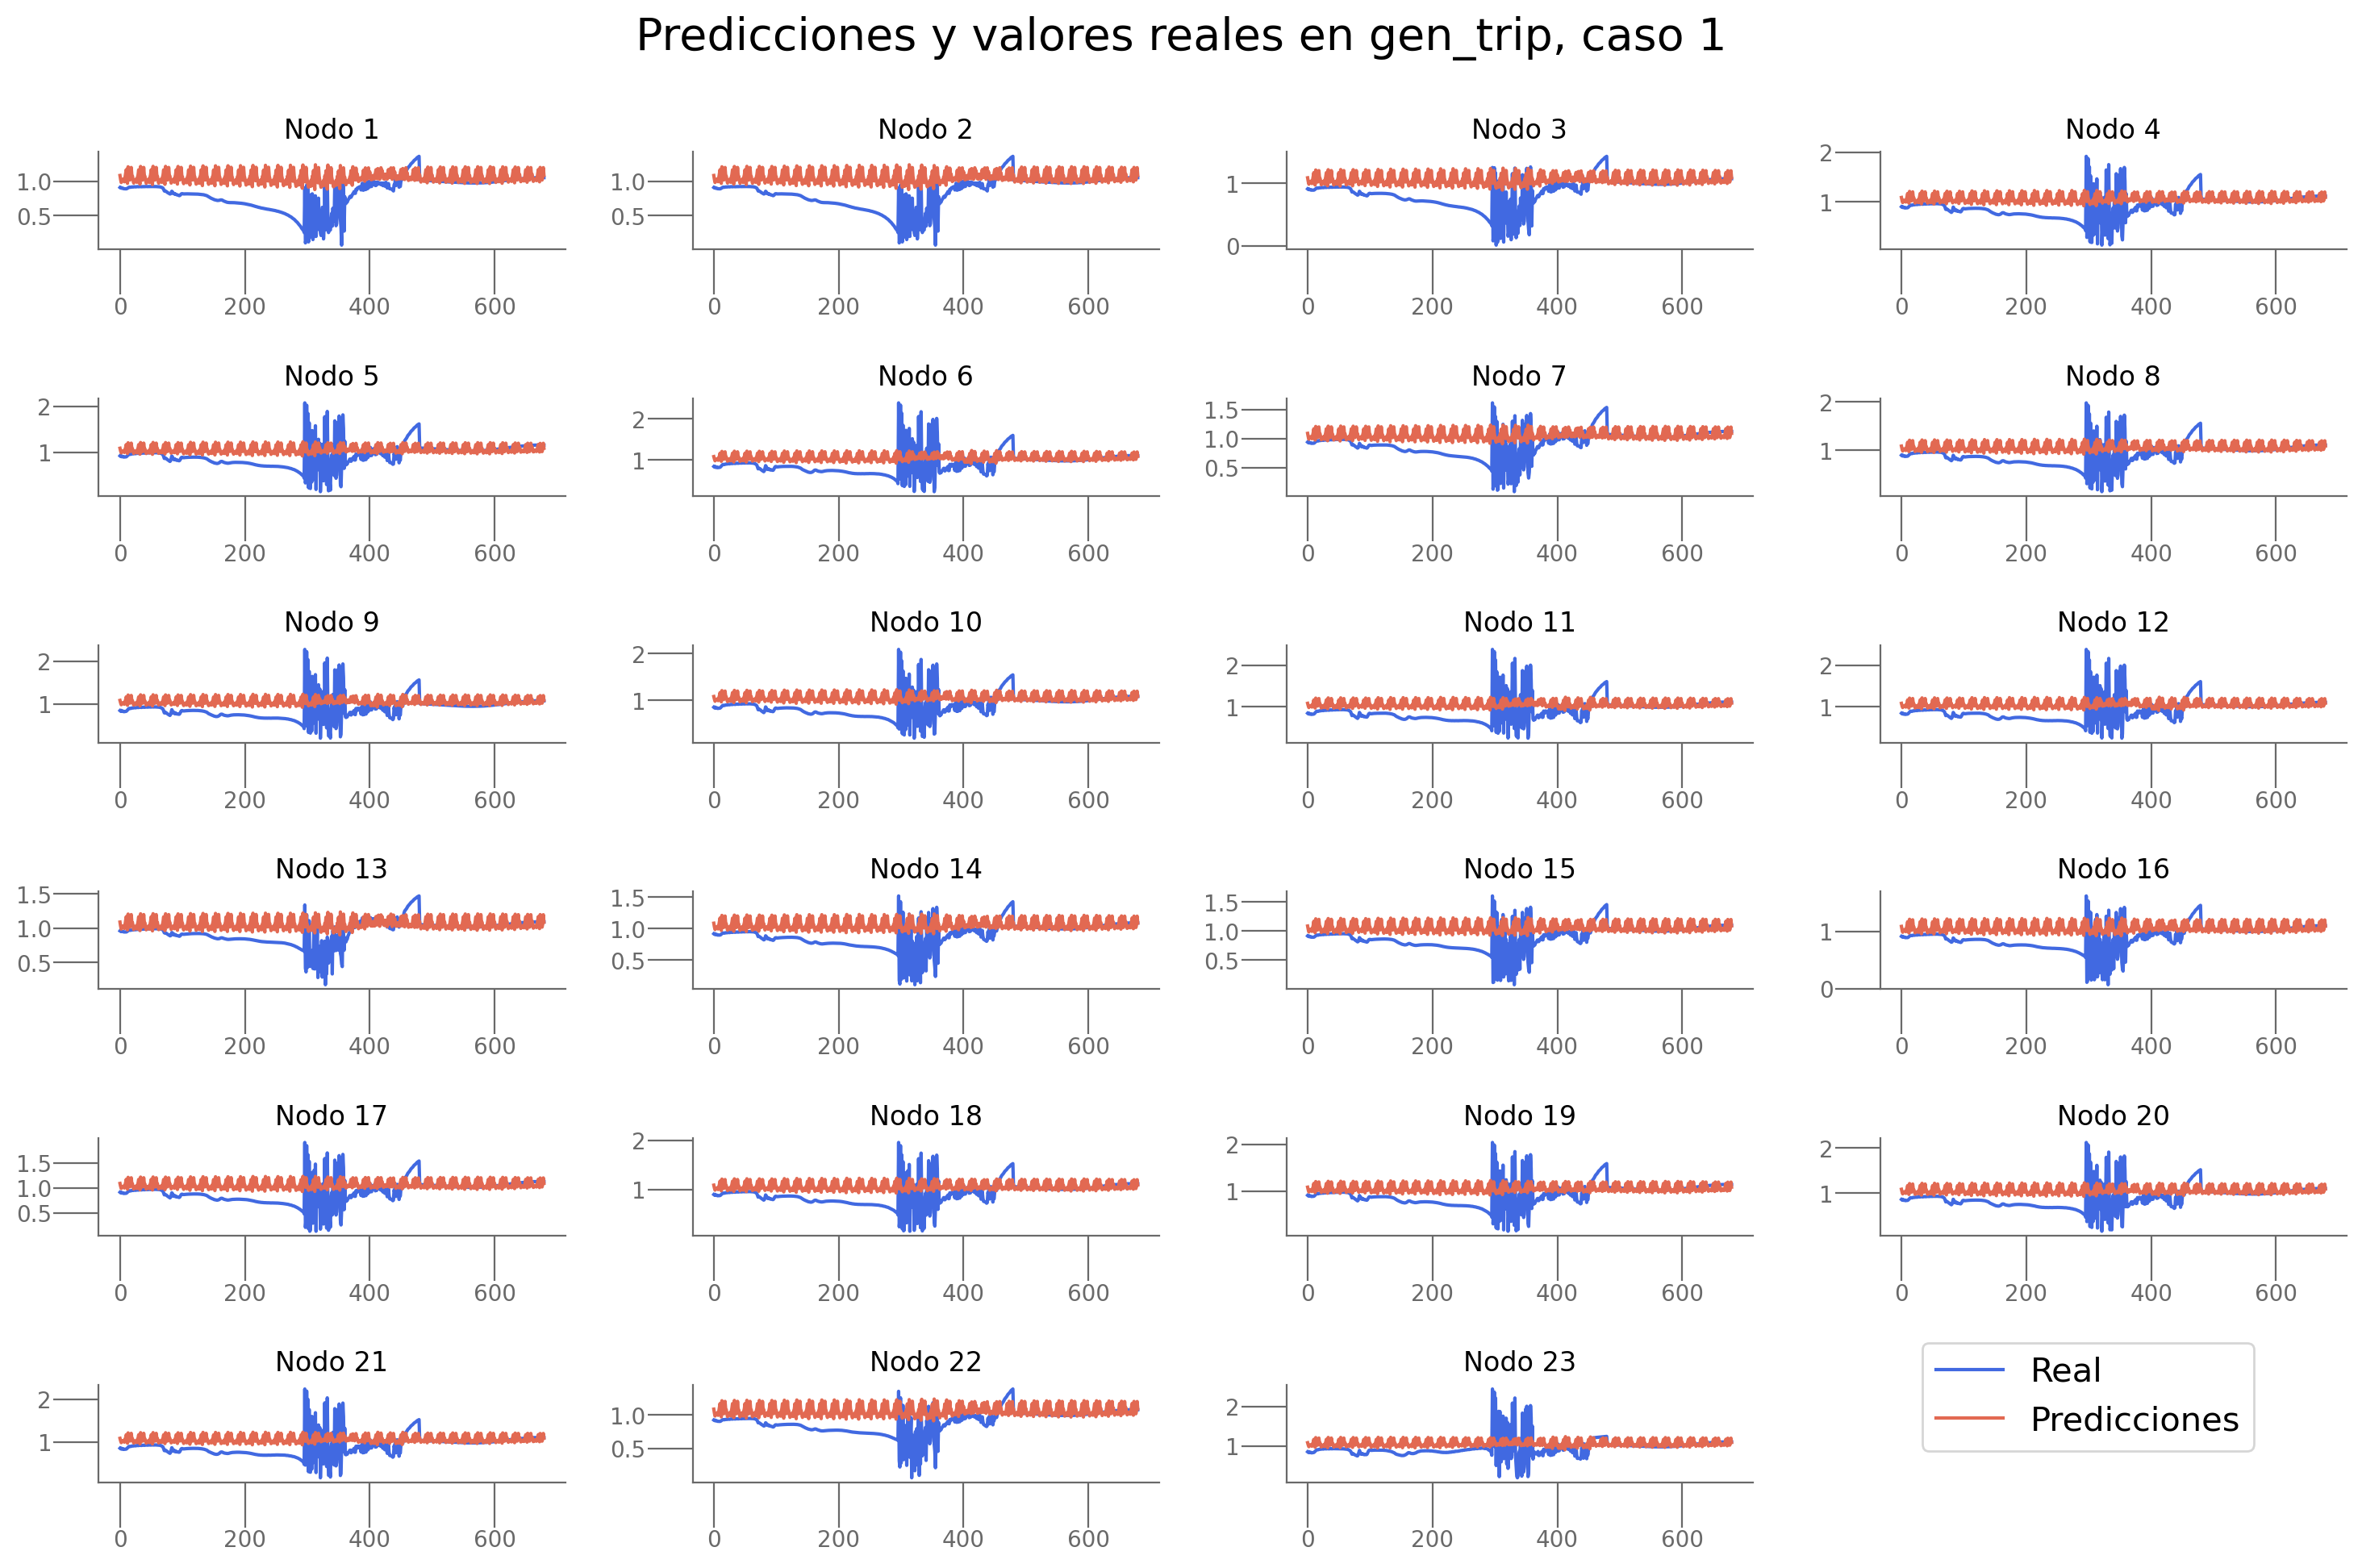

In [24]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 